In [1]:
import os
import math
import random
import numpy as np
import matplotlib.pyplot as plt
plt.style.use("ggplot")
%matplotlib inline

from skimage.io import imshow
#from sklearn.model_selection import train_test_split

#import tensorflow as tf

import keras

from keras.preprocessing.image import img_to_array, load_img
from keras.layers import Conv2D
from keras.models import Model
from keras.optimizers import Adam
from keras import backend as K

np.random.seed(1337)

Using TensorFlow backend.


In [2]:
#making sure GPU is in use 
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 8631067452238992672
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 11285289370
locality {
  bus_id: 1
  links {
  }
}
incarnation: 3530052911151684181
physical_device_desc: "device: 0, name: Tesla K80, pci bus id: 0000:00:04.0, compute capability: 3.7"
]


In [3]:
# Set some parameters
in_height = 64
in_width = 64
out_height = 256
out_width = 256
color_dim = 3
path_in = '/home/Matthew/image-super-resolution/data/imagenet/10k/res64noisy/'
path_out = '/home/Matthew/image-super-resolution/data/imagenet/10k/res256/'

In [4]:
#todo: add random shuffle . seed = 0

def load_images(path_in, path_out, test_size, valid_size):
    images = next(os.walk(path_in))[2] #oswalk is a generator 
    num_images = len(images)
  
    testSize  = int(test_size * num_images)
    validSize = int(valid_size * num_images)
    trainSize = int(math.ceil((1-(test_size+valid_size)) * num_images))
    
    X_train = np.zeros((trainSize,in_height,in_width,color_dim), dtype=np.float32)
    X_test = np.zeros((testSize,in_height,in_width,color_dim), dtype=np.float32)
    X_valid = np.zeros((validSize,in_height,in_width,color_dim), dtype=np.float32)

    y_train = np.zeros((trainSize,out_height,out_width,color_dim), dtype=np.float32)
    y_test  = np.zeros((testSize,out_height,out_width,color_dim), dtype=np.float32)
    y_valid  = np.zeros((validSize,out_height,out_width,color_dim), dtype=np.float32)
    
    trainIdx = 0
    testIdx = 0
    validIdx = 0
    for idx, image in enumerate(images):
        image_in_path = os.path.join(path_in,image)
        image_out_path = os.path.join(path_out,image)

        image_in_raw =  load_img(image_in_path, grayscale=False)
        image_out_raw = load_img(image_out_path, grayscale=False)

        #converts image to keras preprocessing image, then divide by 255 to un-invert the images
        image_in = (img_to_array(image_in_raw)).squeeze() / 255 
        image_out = (img_to_array(image_out_raw)).squeeze() / 255          
 
        try:
            if (idx % 1000 == 0):
                print("Stage " + str(idx))
        
            if (idx < testSize):
                #print("testIdx " + str(testIdx))
                X_test[testIdx] = image_in
                y_test[testIdx] = image_out
                testIdx+=1
                
            elif (idx < testSize + validSize):
                #print("validIdx " + str(validIdx))
                X_valid[validIdx] = image_in
                y_valid[validIdx] = image_out
                validIdx+=1
                
            else:
                #print("trainIdx " + str(trainIdx))
                X_train[trainIdx] = image_in
                y_train[trainIdx] = image_out
                trainIdx+=1
                
        except Exception as e: 
            print("\nERROR!!!!")
            print(image_in.shape)
            print(trainIdx)
            
            print(image_out.shape)
            print(testIdx)
            
            print("id "+str(idx))
            print(image_in_path)
            print(e)
           
            print("\n")
            
    return X_train,X_valid,X_test,y_train,y_valid,y_test

In [5]:
X_train,X_valid,X_test,y_train,y_valid,y_test = load_images(path_in, path_out, .2, .2)

Stage 0
Stage 1000
Stage 2000
Stage 3000
Stage 4000
Stage 5000
Stage 6000
Stage 7000
Stage 8000
Stage 9000


In [6]:
print(len(X_train))
print(len(X_valid))
print(len(X_test))

6000
2000
2000


In [7]:
from keras.models import Sequential
from keras.layers.convolutional import Conv2D
from keras.layers.core import Activation
from keras import backend as K
from keras.layers import Conv2D,MaxPooling2D,UpSampling2D
from keras.optimizers import RMSprop
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

In [8]:
#https://github.com/zeoya/Keras-Super-Resolution/blob/master/myUtils/srcnn.py

In [9]:
#padding output size: see http://cs231n.github.io/convolutional-networks/
# output = (W−F+2P)/S+1   w- input size, f-kernel size, p-padding size 

In [10]:
model = Sequential()
inputShape = (in_height, in_width, color_dim)
model.add(UpSampling2D((4,4),input_shape=inputShape))
model.add(Conv2D(32, (9, 9), padding='same', kernel_initializer="he_normal")) # 256 X 256 X 32
model.add(Activation("relu"))
model.add(Conv2D(16, (7, 7), padding='same', kernel_initializer="he_normal")) # 256 X 256 X 16
model.add(Activation("relu"))
model.add(Conv2D(16, (5, 5), padding='same', kernel_initializer="he_normal")) # 256 X 256 X 16
model.add(Activation("relu"))
model.add(Conv2D(color_dim, (5, 5), padding='same', kernel_initializer="he_normal")) # 256 X 256 X 3
model.add(Activation("sigmoid"))

In [11]:
'''model = Sequential()
inputShape = (in_height, in_width, color_dim)
model.add(UpSampling2D((4,4),input_shape=inputShape))
model.add(Conv2D(32, (9, 9), padding='same', kernel_initializer="he_normal")) # 256 X 256 X 32
model.add(Activation("relu"))
model.add(Conv2D(16, (7, 7), padding='same', kernel_initializer="he_normal")) # 256 X 256 X 16
model.add(Activation("relu"))
model.add(Conv2D(color_dim, (5, 5), padding='same', kernel_initializer="he_normal")) # 256 X 256 X 3
model.add(Activation("sigmoid"))'''

'model = Sequential()\ninputShape = (in_height, in_width, color_dim)\nmodel.add(UpSampling2D((4,4),input_shape=inputShape))\nmodel.add(Conv2D(32, (9, 9), padding=\'same\', kernel_initializer="he_normal")) # 256 X 256 X 32\nmodel.add(Activation("relu"))\nmodel.add(Conv2D(16, (7, 7), padding=\'same\', kernel_initializer="he_normal")) # 256 X 256 X 16\nmodel.add(Activation("relu"))\nmodel.add(Conv2D(color_dim, (5, 5), padding=\'same\', kernel_initializer="he_normal")) # 256 X 256 X 3\nmodel.add(Activation("sigmoid"))'

In [12]:
model.compile(loss='mean_squared_error', optimizer = RMSprop(),metrics=['accuracy'])

In [13]:
model.summary() 

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
up_sampling2d_1 (UpSampling2 (None, 256, 256, 3)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 256, 256, 32)      7808      
_________________________________________________________________
activation_1 (Activation)    (None, 256, 256, 32)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 256, 256, 16)      25104     
_________________________________________________________________
activation_2 (Activation)    (None, 256, 256, 16)      0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 256, 256, 16)      6416      
_________________________________________________________________
activation_3 (Activation)    (None, 256, 256, 16)      0         
__________

In [14]:

callbacks = [
    EarlyStopping(patience=10, verbose=1),
    ReduceLROnPlateau(factor=0.1, patience=3, min_lr=0.00001, verbose=1),
    ModelCheckpoint('model_15.h5', verbose=1, save_best_only=True, save_weights_only=True)
]


In [15]:
batch_size = 256
epochs = 30

trainHistory = model.fit(X_train, y_train, batch_size=batch_size,epochs=epochs,verbose=1,validation_data=(X_valid, y_valid),callbacks=callbacks)

Train on 6000 samples, validate on 2000 samples
Epoch 1/30
6000/6000 [==============================] - 132s 22ms/step - loss: 0.0634 - acc: 0.4524 - val_loss: 0.0284 - val_acc: 0.6068

Epoch 00001: val_loss improved from inf to 0.02839, saving model to model_15.h5
Epoch 2/30
6000/6000 [==============================] - 99s 17ms/step - loss: 0.0312 - acc: 0.5879 - val_loss: 0.0627 - val_acc: 0.4937

Epoch 00002: val_loss did not improve from 0.02839
Epoch 3/30
6000/6000 [==============================] - 99s 16ms/step - loss: 0.0292 - acc: 0.6048 - val_loss: 0.0210 - val_acc: 0.5605

Epoch 00003: val_loss improved from 0.02839 to 0.02103, saving model to model_15.h5
Epoch 4/30
6000/6000 [==============================] - 99s 16ms/step - loss: 0.0257 - acc: 0.6114 - val_loss: 0.0209 - val_acc: 0.6250

Epoch 00004: val_loss improved from 0.02103 to 0.02090, saving model to model_15.h5
Epoch 5/30
6000/6000 [==============================] - 99s 16ms/step - loss: 0.0261 - acc: 0.6224 - val

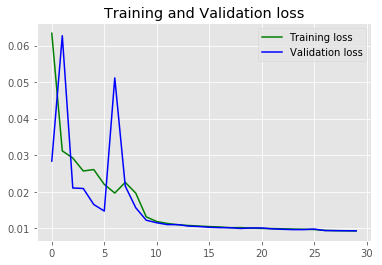

In [16]:
loss = trainHistory.history['loss']
val_loss = trainHistory.history['val_loss']
epochsRange = range(len(trainHistory.history['loss']))
plt.figure()
plt.plot(epochsRange, loss, label='Training loss',color='g')
plt.plot(epochsRange, val_loss, label='Validation loss',color='b')
plt.title('Training and Validation loss')
plt.legend()
plt.show()

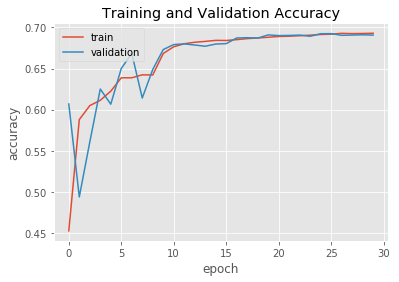

In [17]:
plt.plot(trainHistory.history['acc'])
plt.plot(trainHistory.history['val_acc'])
plt.title('Training and Validation Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [18]:
print(trainHistory.history.keys())

dict_keys(['val_loss', 'acc', 'lr', 'loss', 'val_acc'])


In [19]:
pred = model.predict(X_test)

Test Images


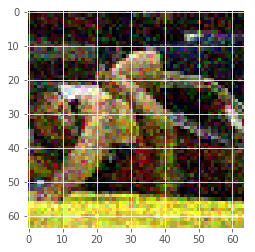

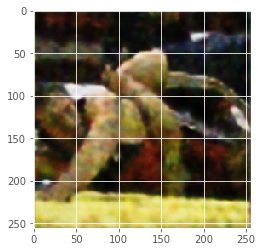

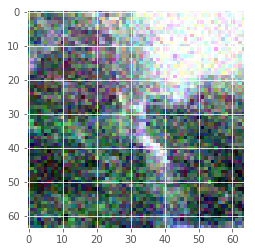

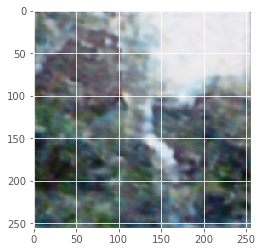

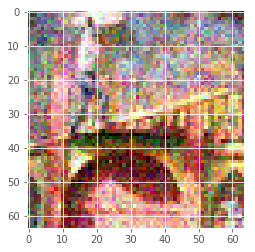

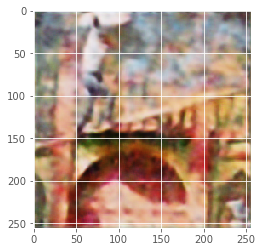

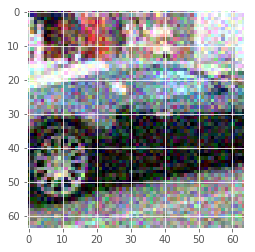

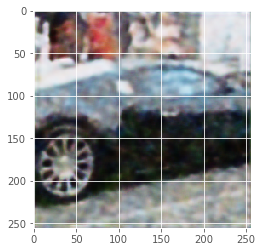

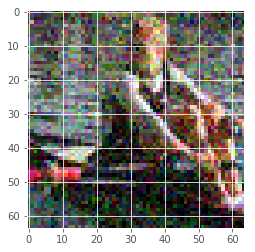

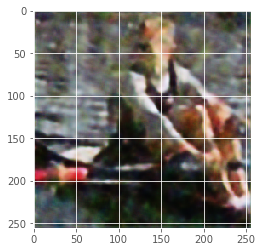

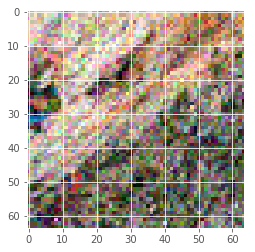

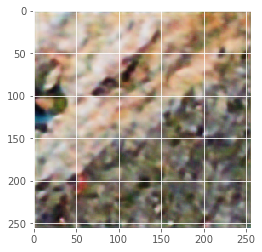

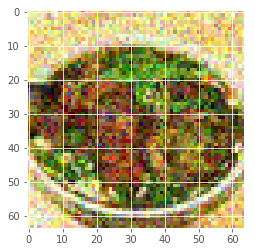

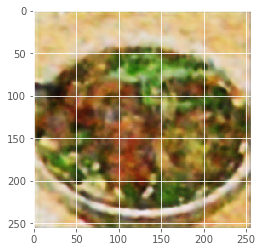

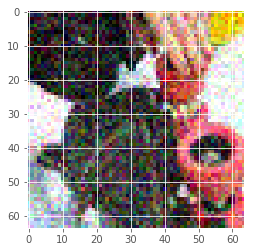

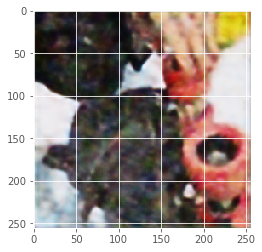

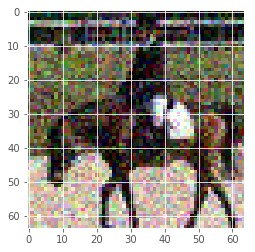

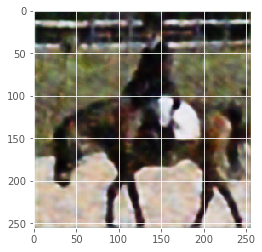

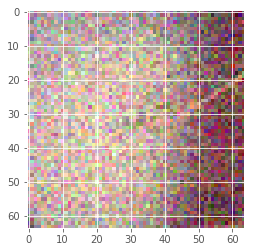

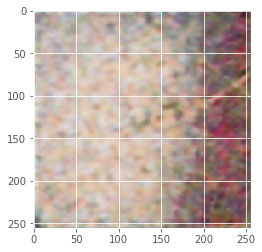

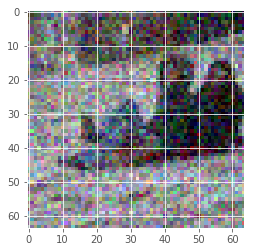

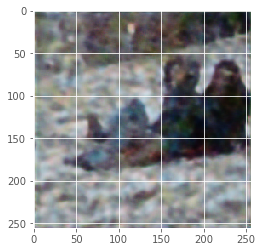

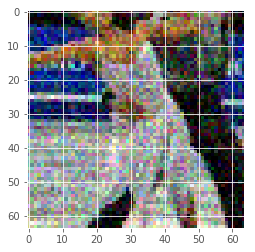

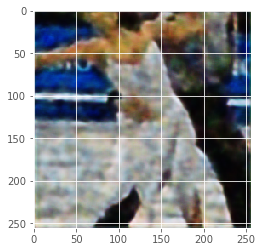

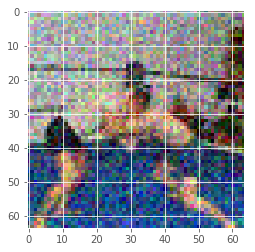

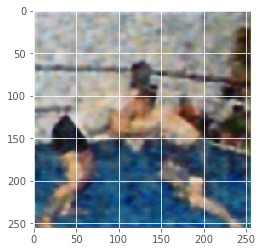

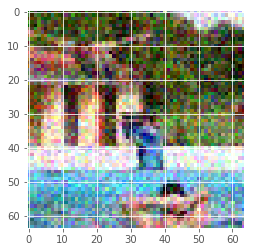

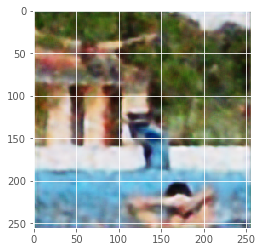

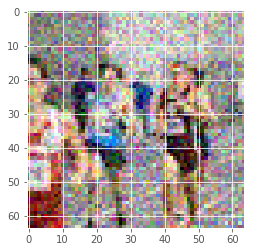

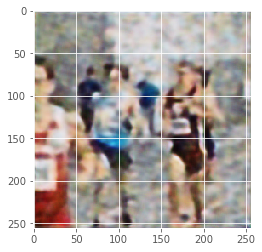

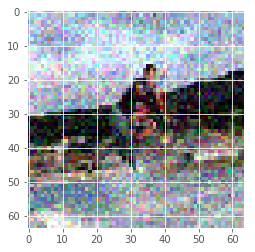

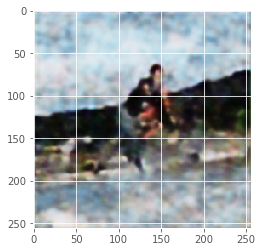

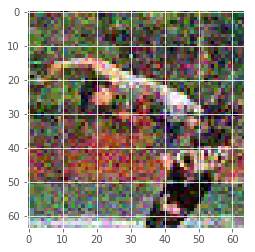

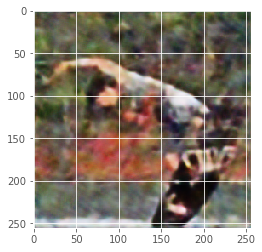

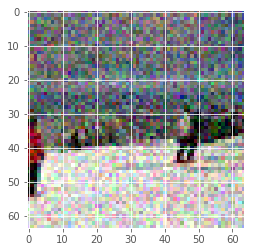

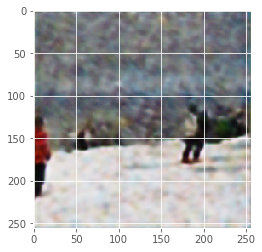

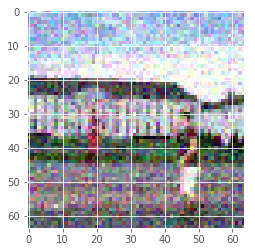

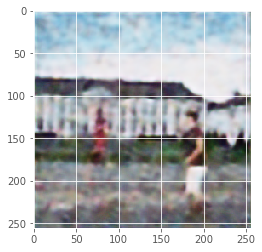

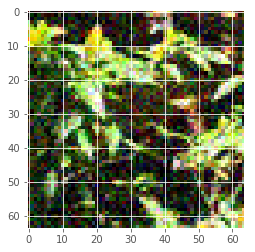

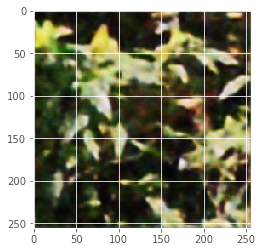

In [20]:
#plt.figure(figsize=(256, 256))
print("Test Images")

for i in range(20):
    #plt.subplot(2, 10, i+1)
    plt.imshow(X_test[i])
    plt.show()
    plt.imshow(pred[i])
    #curr_lbl = y_test[i]
    #plt.title("(Label: " + str(label_dict[curr_lbl]) + ")")
    plt.show()
#plt.figure(figsize=(256, 256))
#print("Reconstruction of Test Images")
#for i in range(10):
    #plt.subplot(2, 10, i+1)
    #plt.imshow(pred[i])  
    #plt.show()

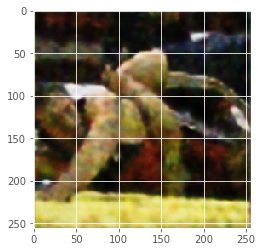

In [21]:
plt.imshow(pred[0])  